# TOP

In [1]:
%reset -f
import ROOT

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0.05)
ROOT.gStyle.SetPadLeftMargin(0.09)
ROOT.gStyle.SetPadBottomMargin(0.11)
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetLabelSize(0.07, 'XY')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.65, 'Y')
ROOT.gStyle.SetMarkerSize(1.8)


%run -i ../eppi0_columns.py


fname="../data/lvl2_eppi0.inb.qa.root"
fname="../data/lvl2_eppi0.outb.qa.root"

dsid = 'inb' if 'inb' in fname else 'outb'

df = ROOT.RDataFrame("h22",fname)

df = define_eppi0_columns_using_proton(df)

%run -i ../eppi0_binning_scheme_v3.py
df  = define_eppi0_bins(df,dsid)

ecorrfile = '../code/utsav.inb.ele3phis.code' if 'inb' in fname else '../code/utsav.outb.ele3phis.code'
with open(ecorrfile) as ff:
    df = df.Define("fe", ff.read()+"return fe;")

inbelosscode = """
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(thp>27) dp = exp(-1.2 - 4.228*pp) + 0.007502;
"""
outbelosscode = """
double dp = exp(-2.739 - 3.932*pp) + 0.002907;
if(thp>27) dp = exp(-1.871 - 3.063*pp) + 0.007517;
"""

elosscode = inbelosscode if 'inb' in fname else outbelosscode
df = df.Define("feloss", elosscode + "return (pp+dp)/pp;")

Welcome to JupyROOT 6.24/06


__________________

In [2]:
rdf = df.Define("mm2s","""
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);

TLorentzVector ele0, ele1, pro0, pro1;
ele0.SetXYZM(ex,ey,ez,0);
pro0.SetXYZM(px,py,pz,0.938);

ele1.SetXYZM(fe*ex, fe*ey, fe*ez, 0);
pro1.SetXYZM(feloss*px, feloss*py, feloss*pz, 0.938);

double mm2a = (beam+targ-ele0-pro0).M2();
double mm2b = (beam+targ-ele1-pro0).M2();
double mm2c = (beam+targ-ele0-pro1).M2();
double mm2d = (beam+targ-ele1-pro1).M2();

vector<double> mm2s = {mm2a, mm2b, mm2c, mm2d};
return mm2s;
""").Define("mm2a","mm2s[0]").Define("mm2b","mm2s[1]").Define("mm2c","mm2s[2]").Define("mm2d","mm2s[3]")

In [3]:
h2as,h2bs = [],[]
pelims = [3,4,5, 5.5,6,6.5,7,7.5,8]
for esec in range(1,7):
    bdf0 = rdf.Filter(f"esec=={esec}")
    h2a = bdf0.Histo2D((f"hmm2a pe s{esec}", f"sector {esec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,1,8, 100,-0.5,0.5), "pe", "mm2a")
    h2as.append(h2a)
    h2b = bdf0.Histo2D((f"hmm2b pe s{esec}", f"sector {esec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,1,8, 100,-0.5,0.5), "pe", "mm2b")
    h2bs.append(h2b)
    
    setattr(h2a, "pms", [])
    setattr(h2b, "pms", [])
    setattr(h2a, "h1s", [])
    setattr(h2b, "h1s", [])
    
    for pe0,pe1 in zip(pelims[:-1], pelims[1:]):
        bdf1 = bdf0.Filter(f"pe>{pe0} && pe<{pe1}")
        h1a = bdf1.Histo1D((str(('mm2a',esec,pe0,pe1)), str(('mm2a',esec,pe0,pe1)), 200,-0.5,0.5), "mm2a")
        h1b = bdf1.Histo1D((str(('mm2b',esec,pe0,pe1)), str(('mm2b',esec,pe0,pe1)), 200,-0.5,0.5), "mm2b")
        pm = bdf1.Mean("pe")
        h2a.h1s.append(h1a)
        h2b.h1s.append(h1b)
        h2a.pms.append(pm)
        h2b.pms.append(pm)

-----------------------------

-----------------------------

-----------------------------

# 2D plots of MM2 vs pe

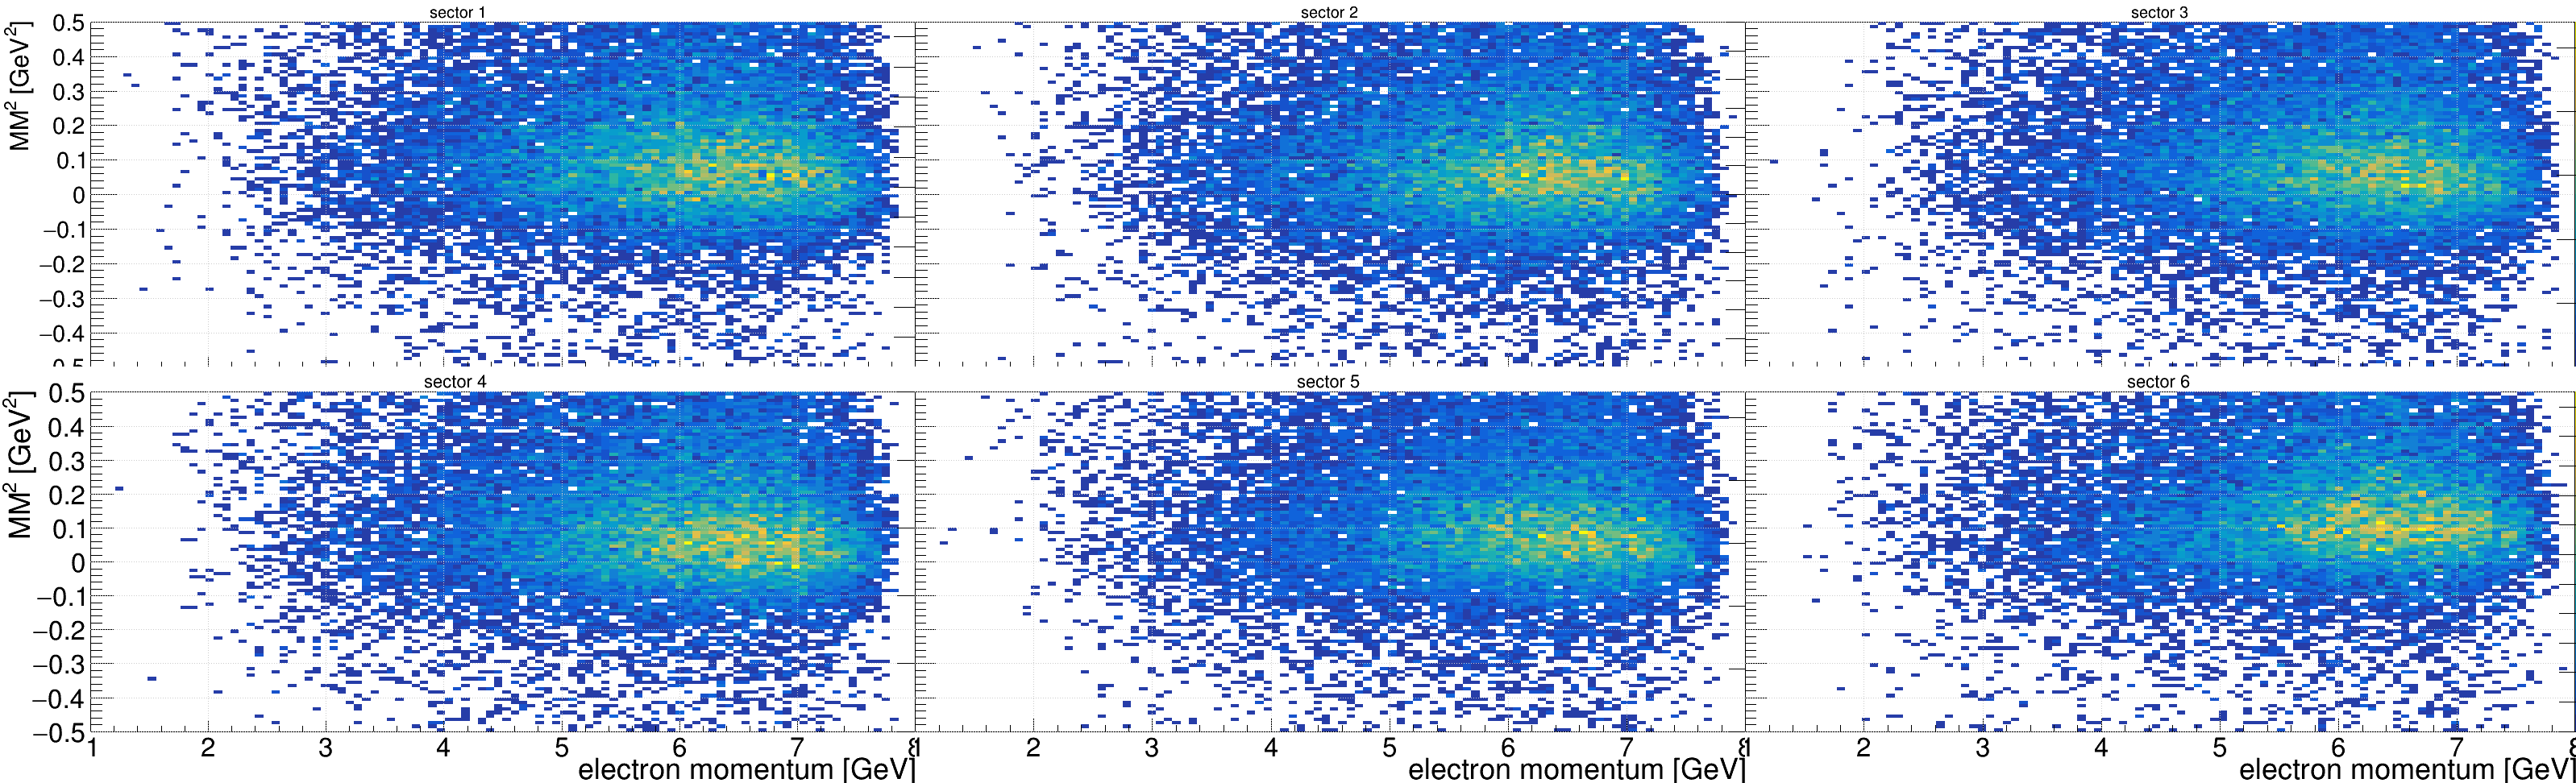

In [4]:
c1 = ROOT.TCanvas("c1","c1",3200,1000)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Draw()
c1.Divide(3,2,0,0)

for esec in range(1,7):
    c1.cd(esec).SetTopMargin(0.06)
    h2as[esec-1].Draw("colz")
c1.Print(f"../pdf/eppi0.ecorr.mm2vspe.{dsid}.pdf")

-----------------------------

-----------------------------

-----------------------------

# Fitting slices

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


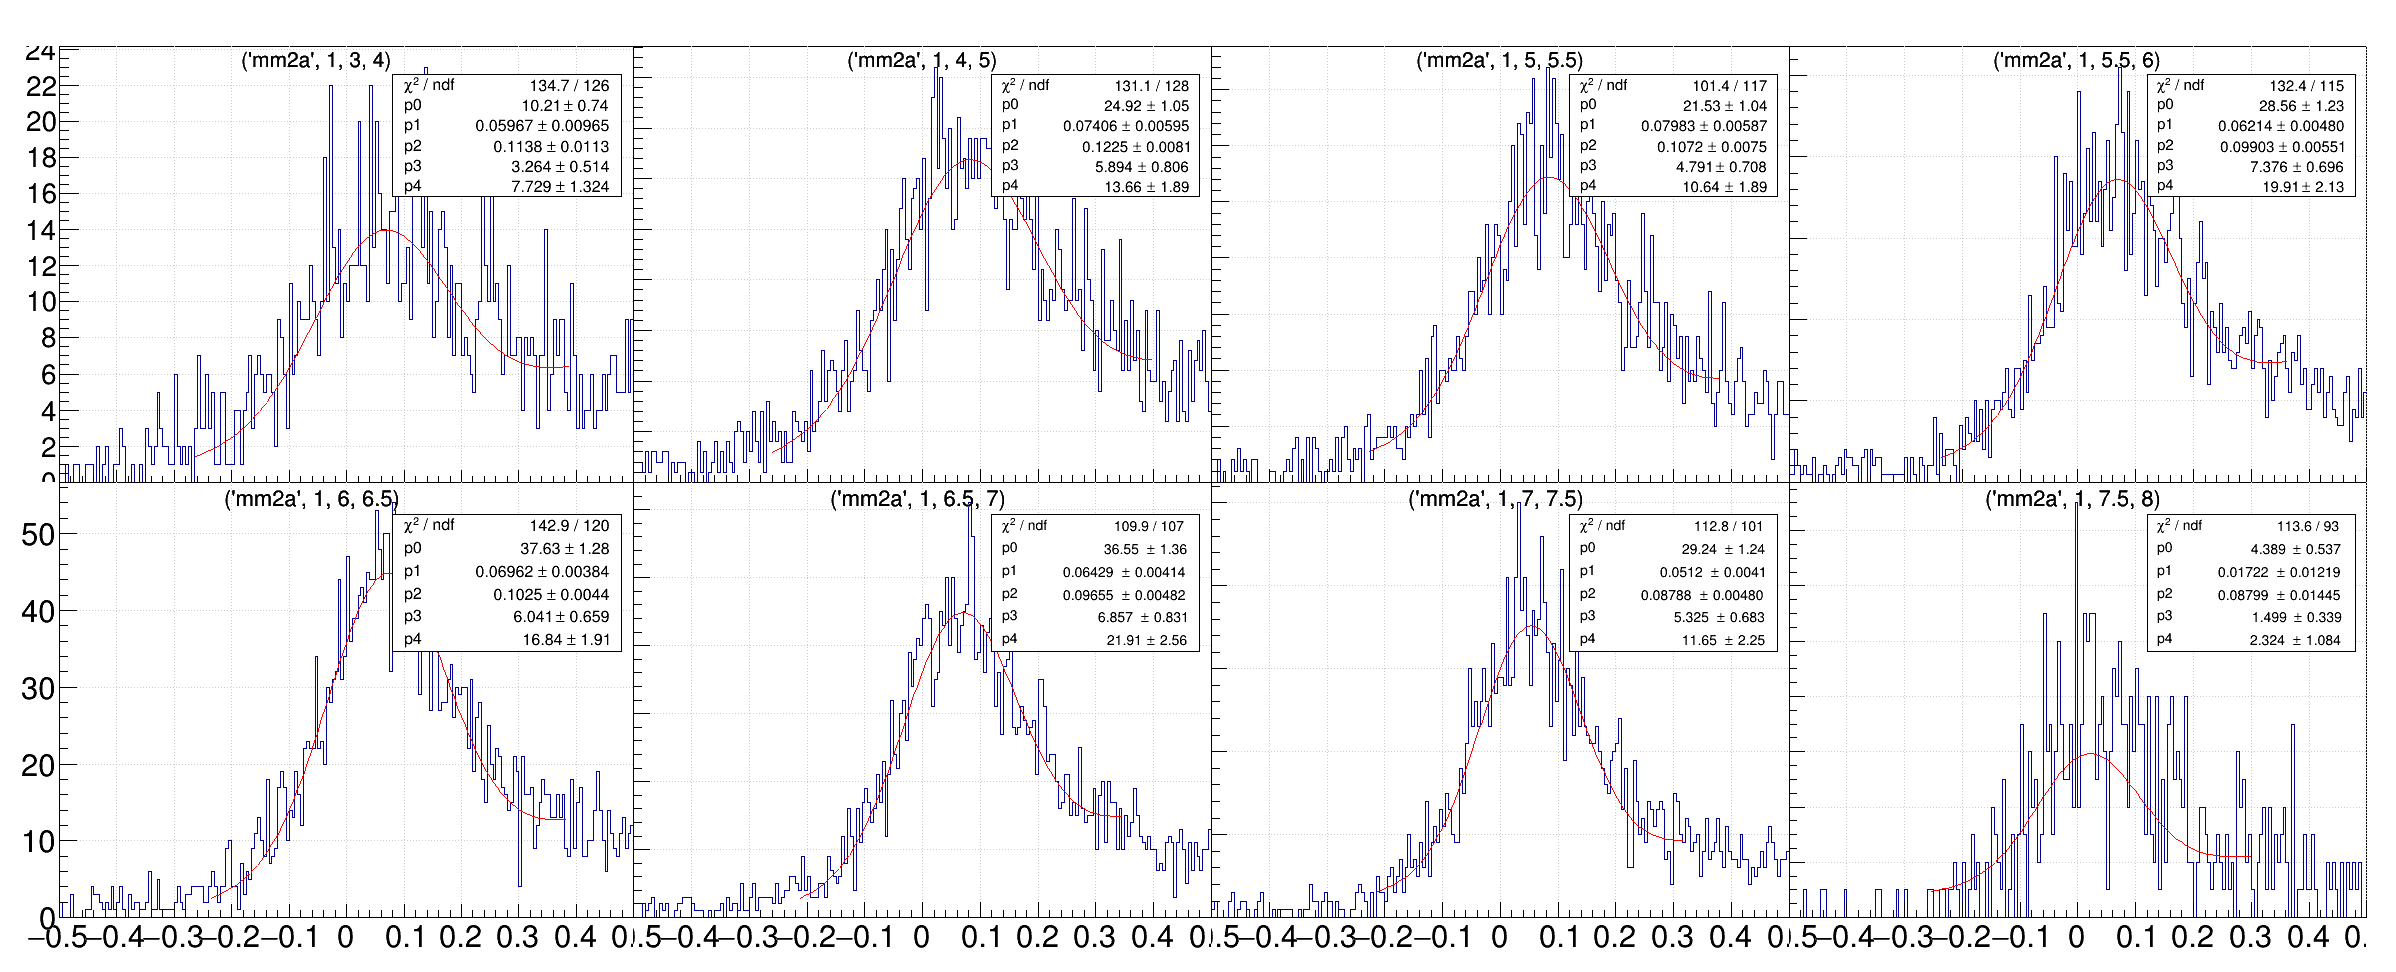

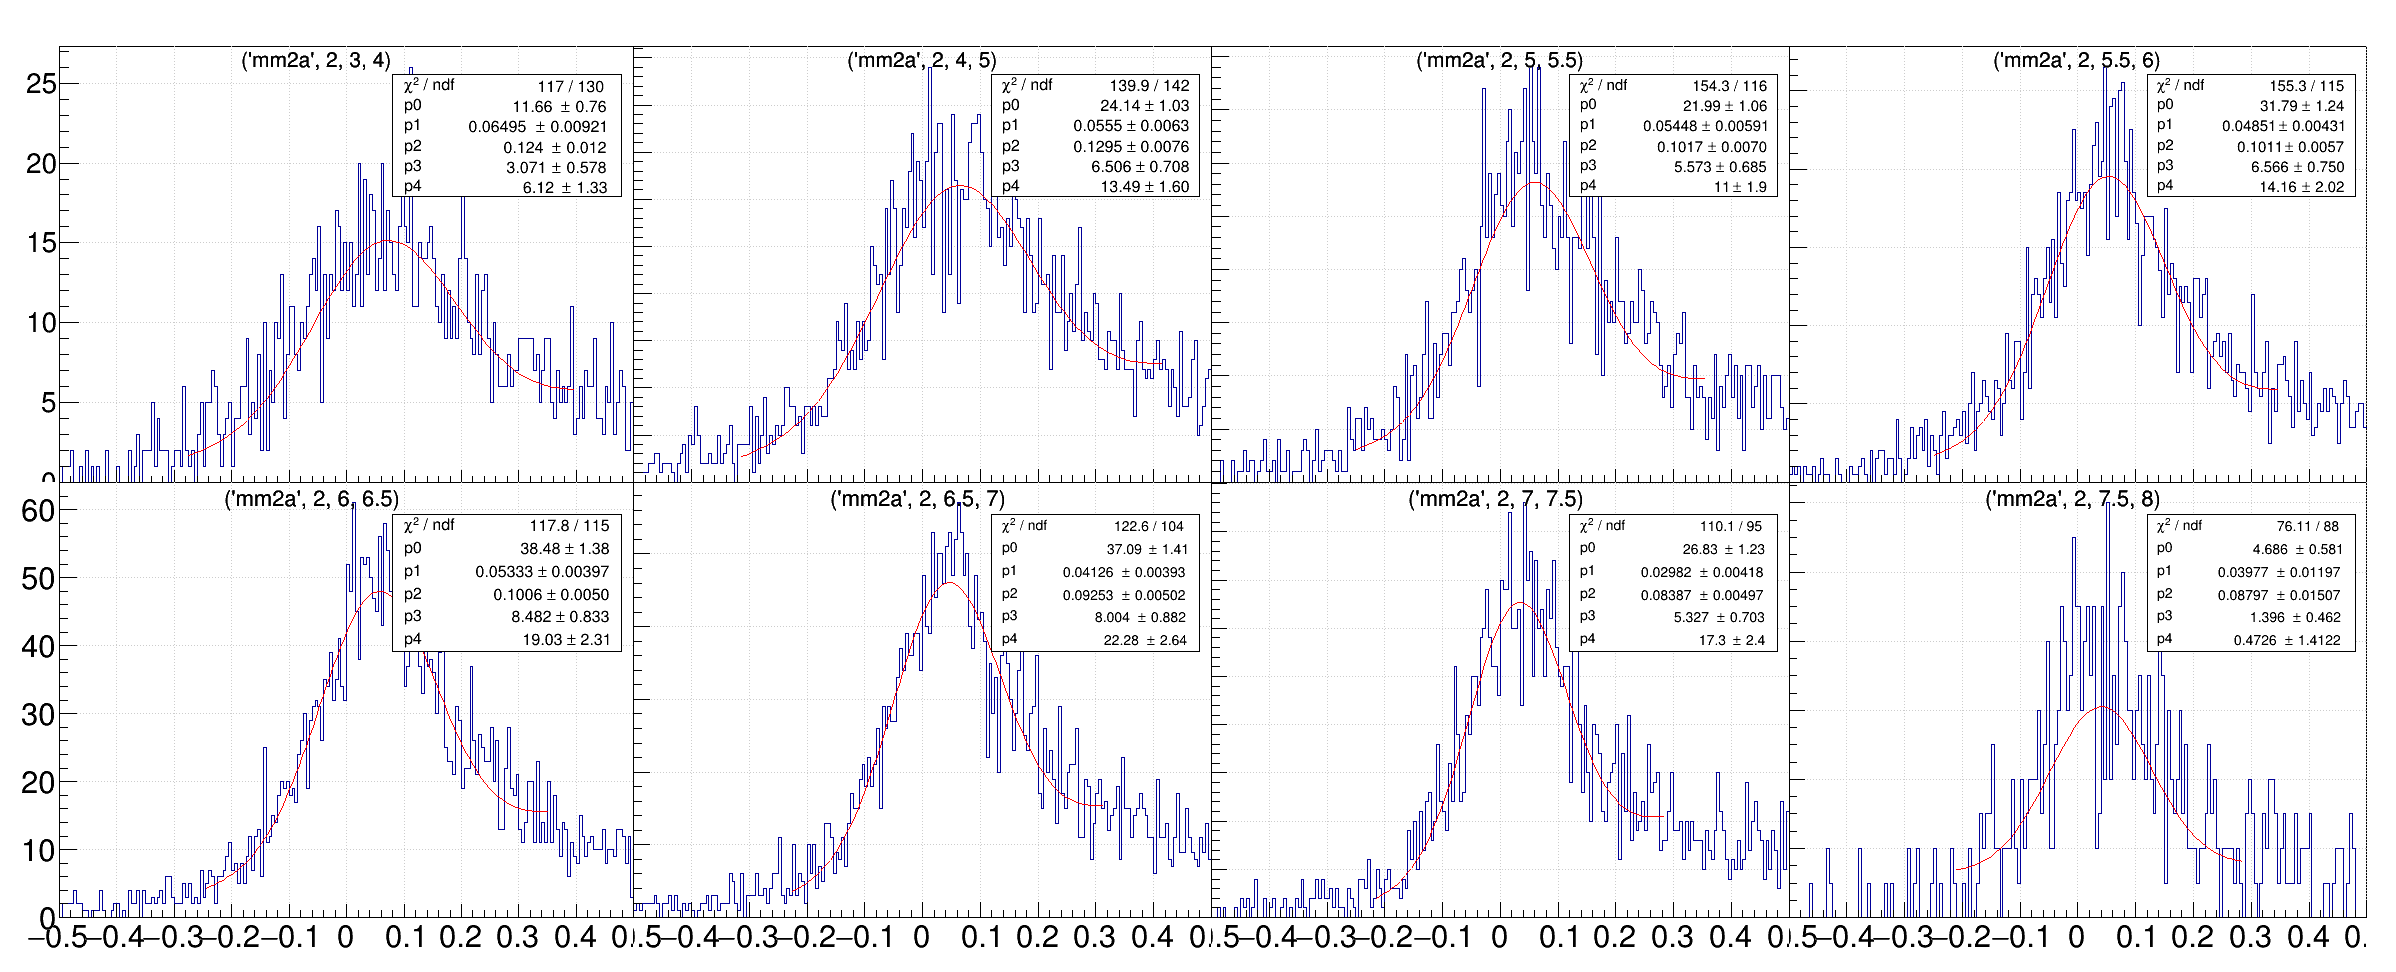

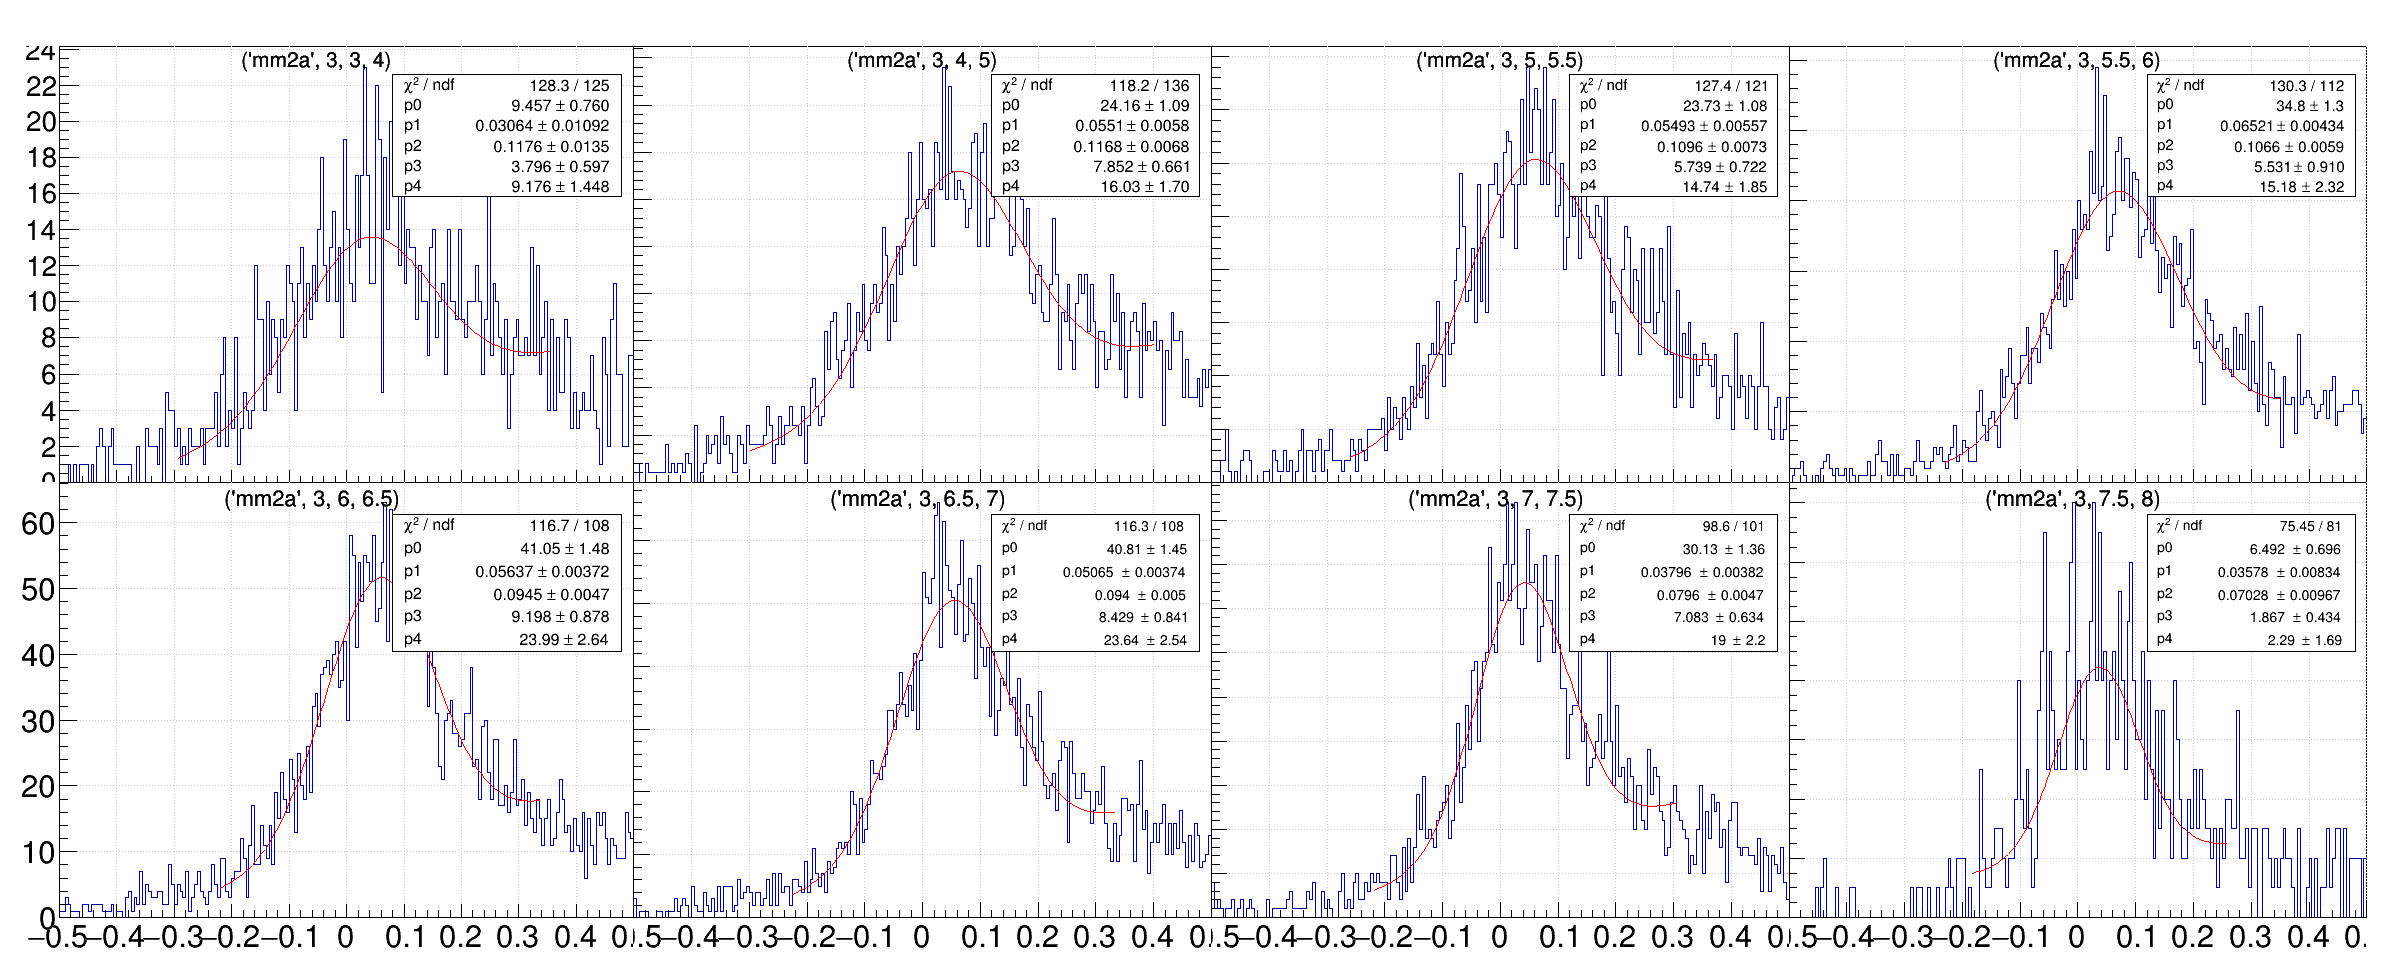

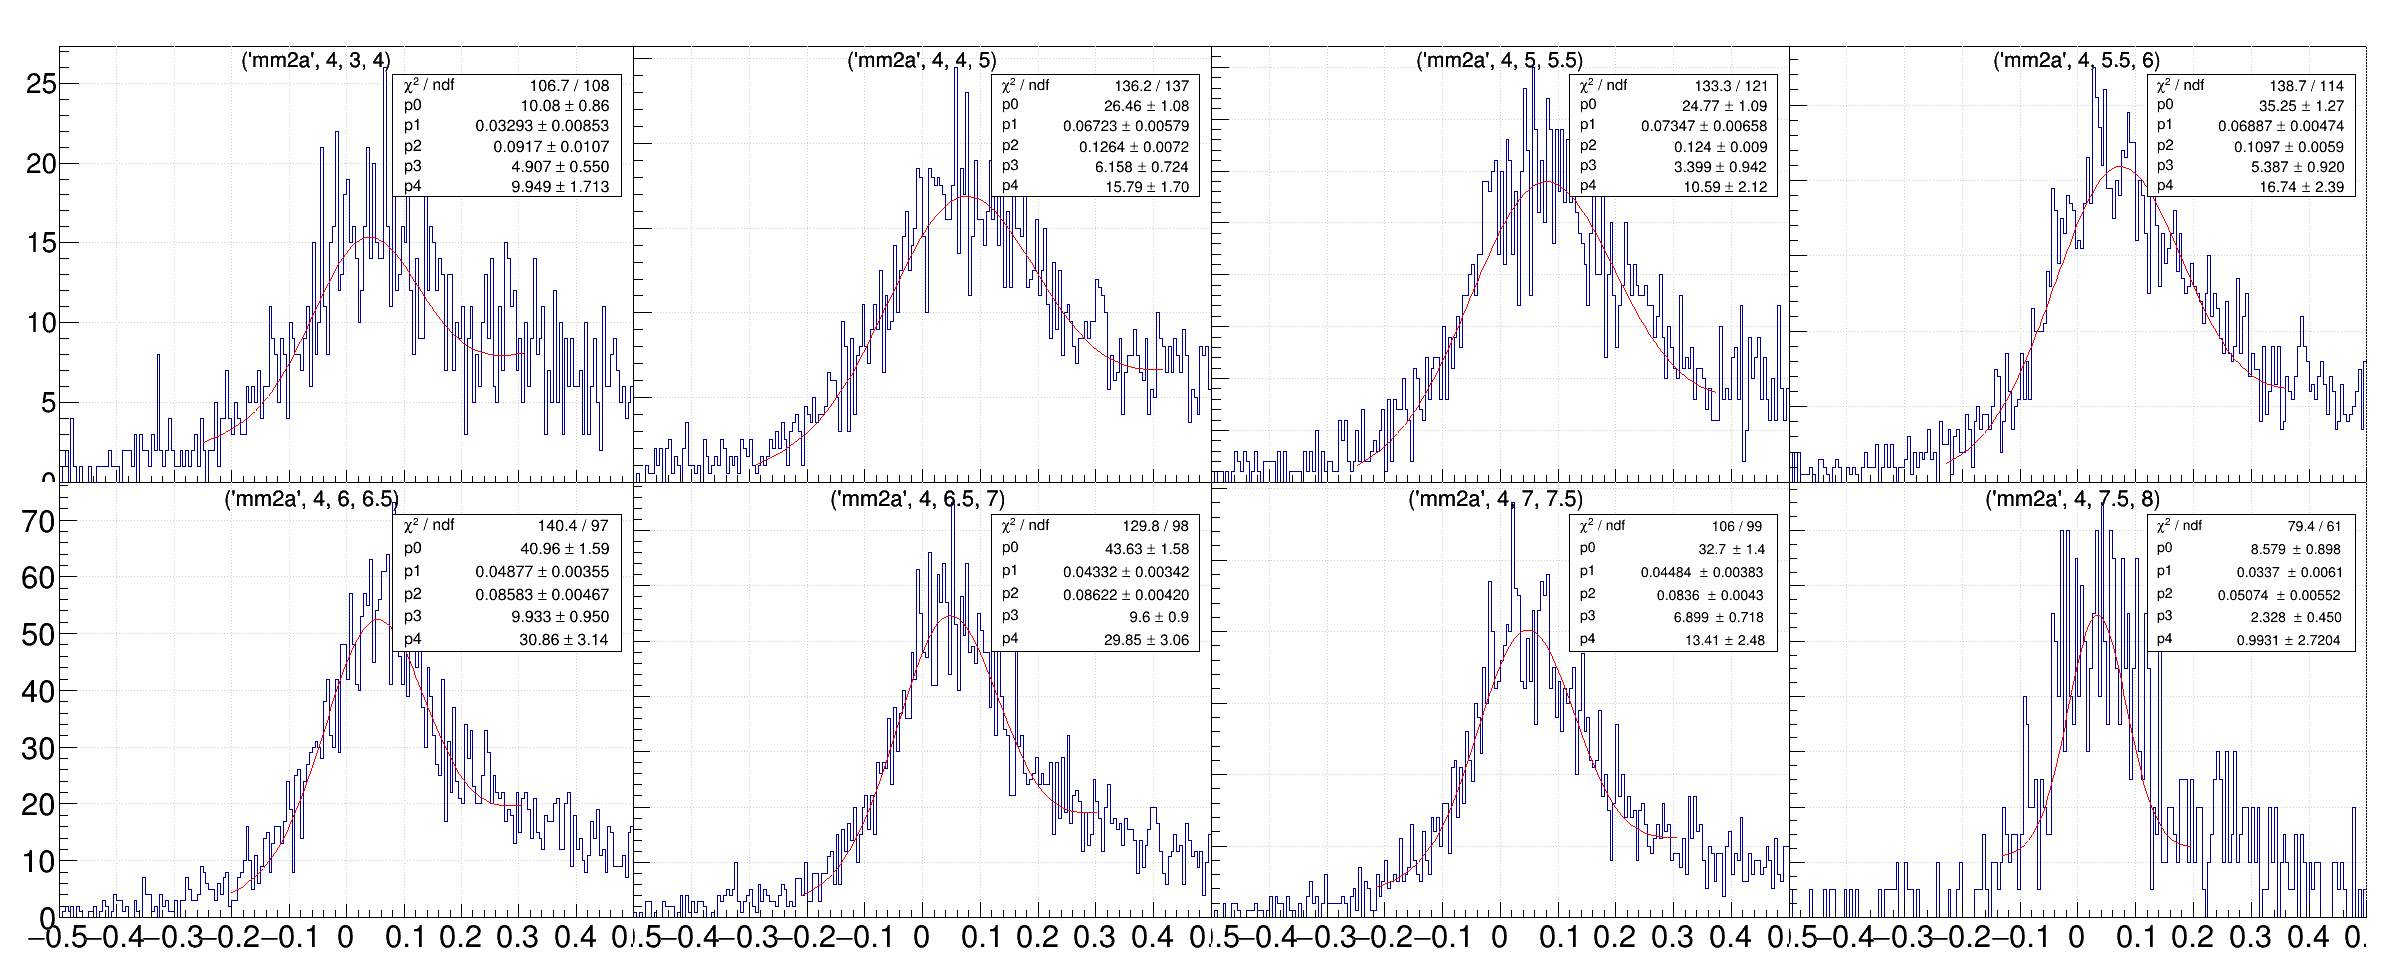

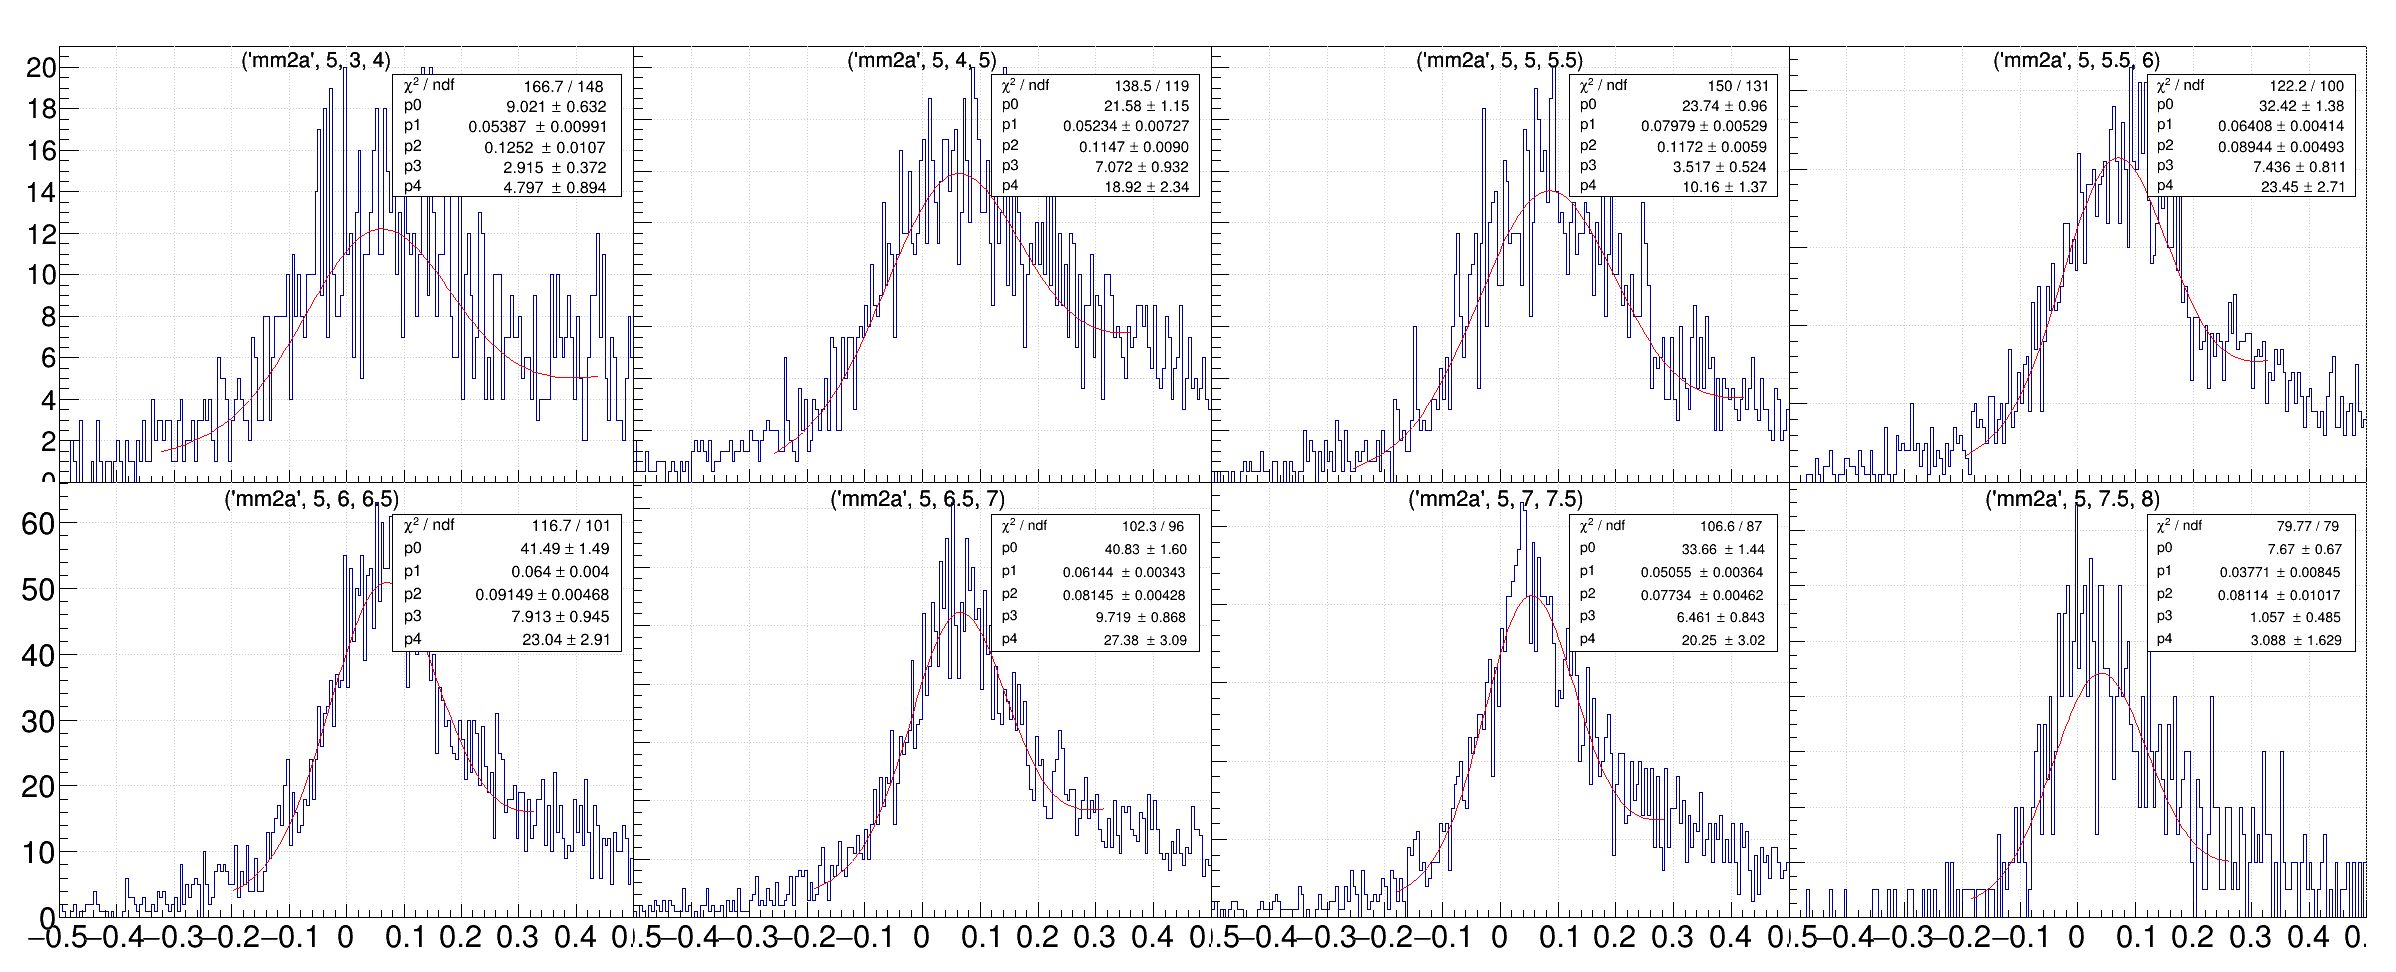

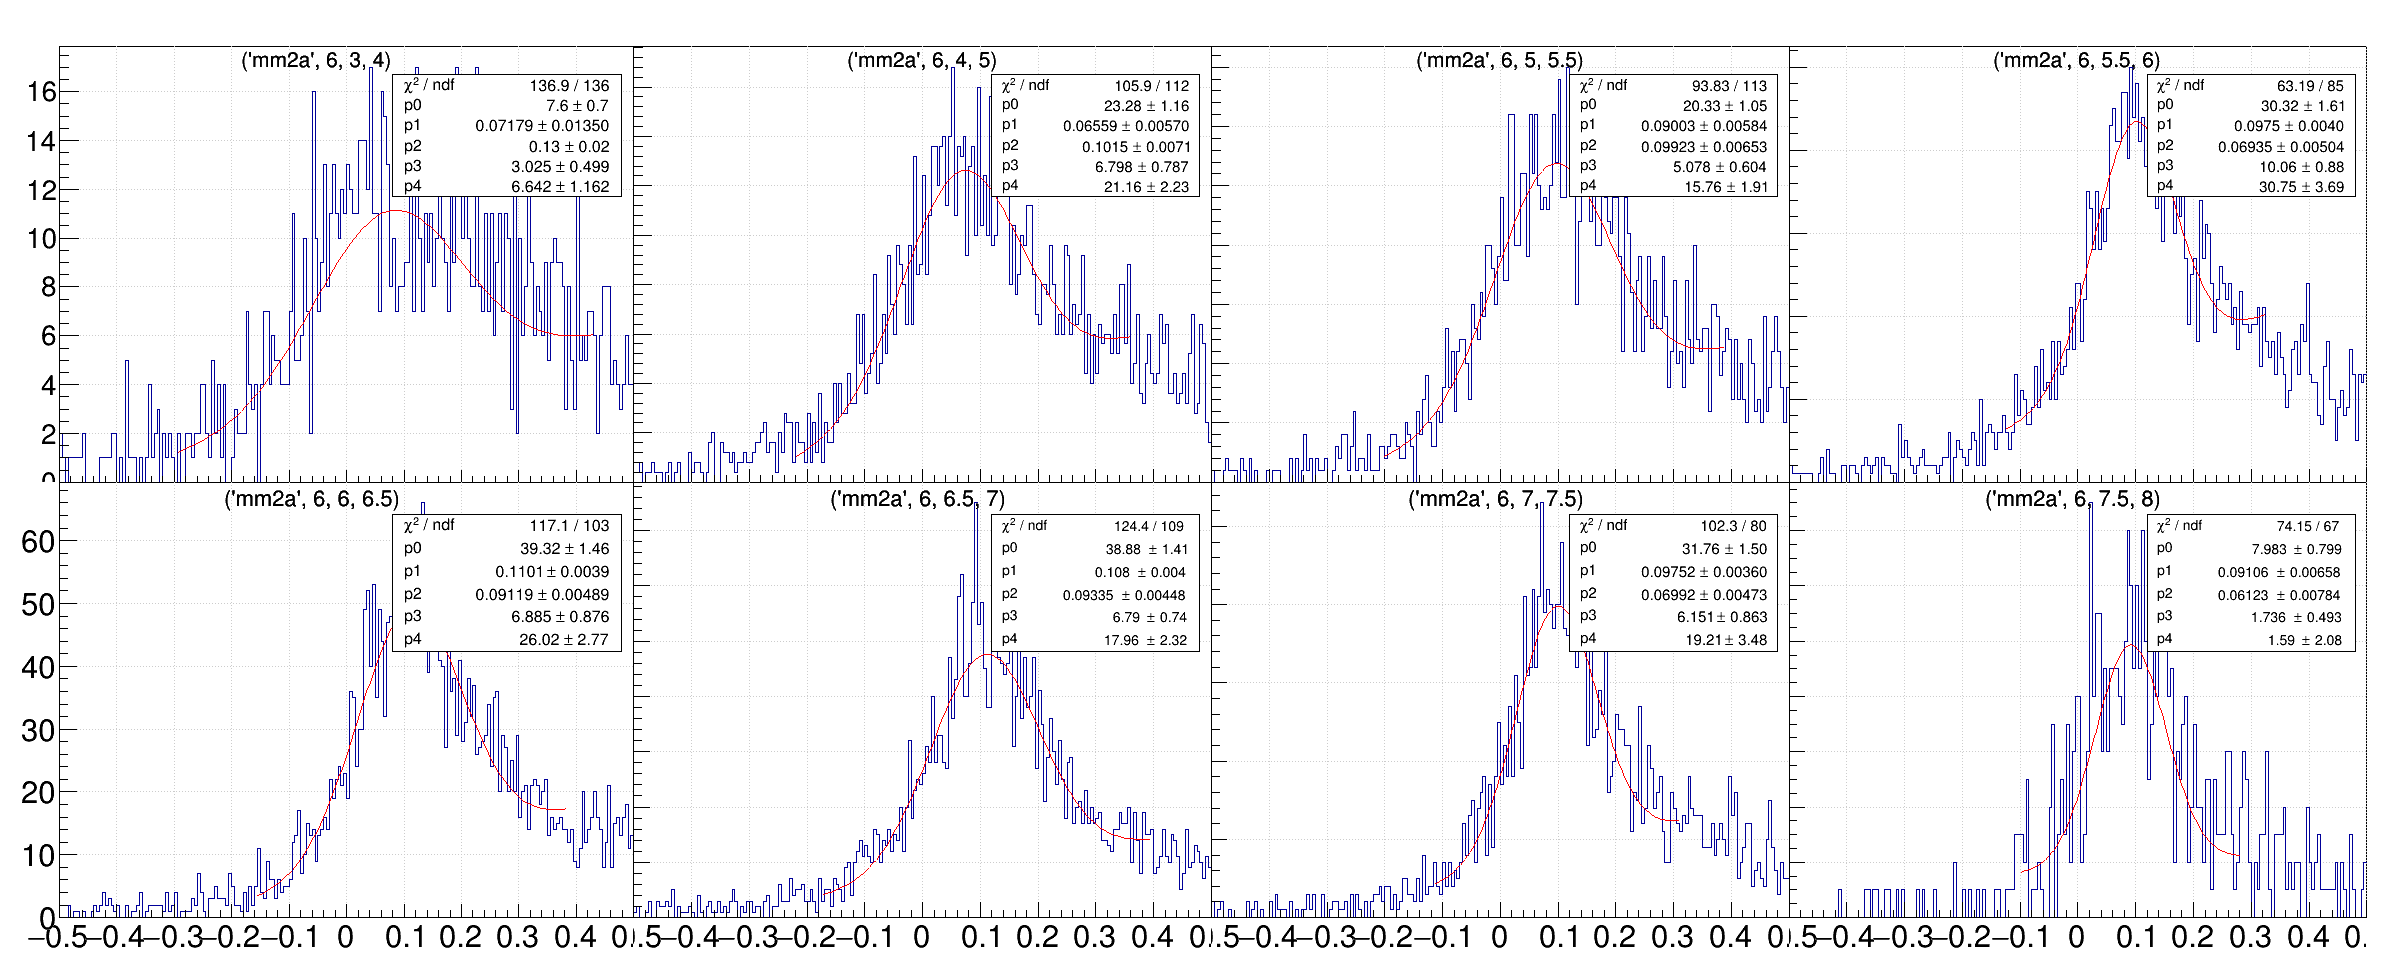

In [5]:
def fitslices(h2):
    setattr(h2, "gr", ROOT.TGraphErrors())
    for pm,h1 in zip(h2.pms, h2.h1s):
        f1 = ROOT.TF1("f1"+h1.GetName(), "gaus(0)+pol1(3)", -0.33,0.34)
        f1.SetLineWidth(1)
        f1.SetParameters(1,0,0.1,1,1)
        f1.SetParLimits(1,-0.1,0.15)
        f1.SetParLimits(2,0.01,0.21)
        h1.Fit(f1,"QR")
        mu,sig = f1.GetParameter(1), f1.GetParameter(2)
        f1.SetRange(mu-3*sig, mu+3*sig)
        h1.Fit(f1,"QR")
        h2.gr.SetPoint(h2.gr.GetN(), pm.GetValue(), f1.GetParameter(1))
        h2.gr.SetPointError(h2.gr.GetN()-1, 0, f1.GetParError(1))

c1s=[]
for sec in range(1,7):
    c1 = ROOT.TCanvas(f"c{sec}","canvas",2400,1000)
    c1.Draw()
    c1s.append(c1)

    h2a,h2b = h2as[sec-1], h2bs[sec-1]

    fitslices(h2a)
    fitslices(h2b)

    c1.Clear()
    c1.Divide(4,2,0,0)
    
    ipad = 0
    for pm,h1 in zip(h2a.pms,h2a.h1s):
        ipad+=1
        c1.cd(ipad)
        h1.Draw()

    #c1.Print(f"eppi0.MM2.ecorr.effect.fits.sec{sec}.nocorr.{dsid}.png")

-----------------------------

-----------------------------

-----------------------------

# Graphs of MM2 vs pe

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


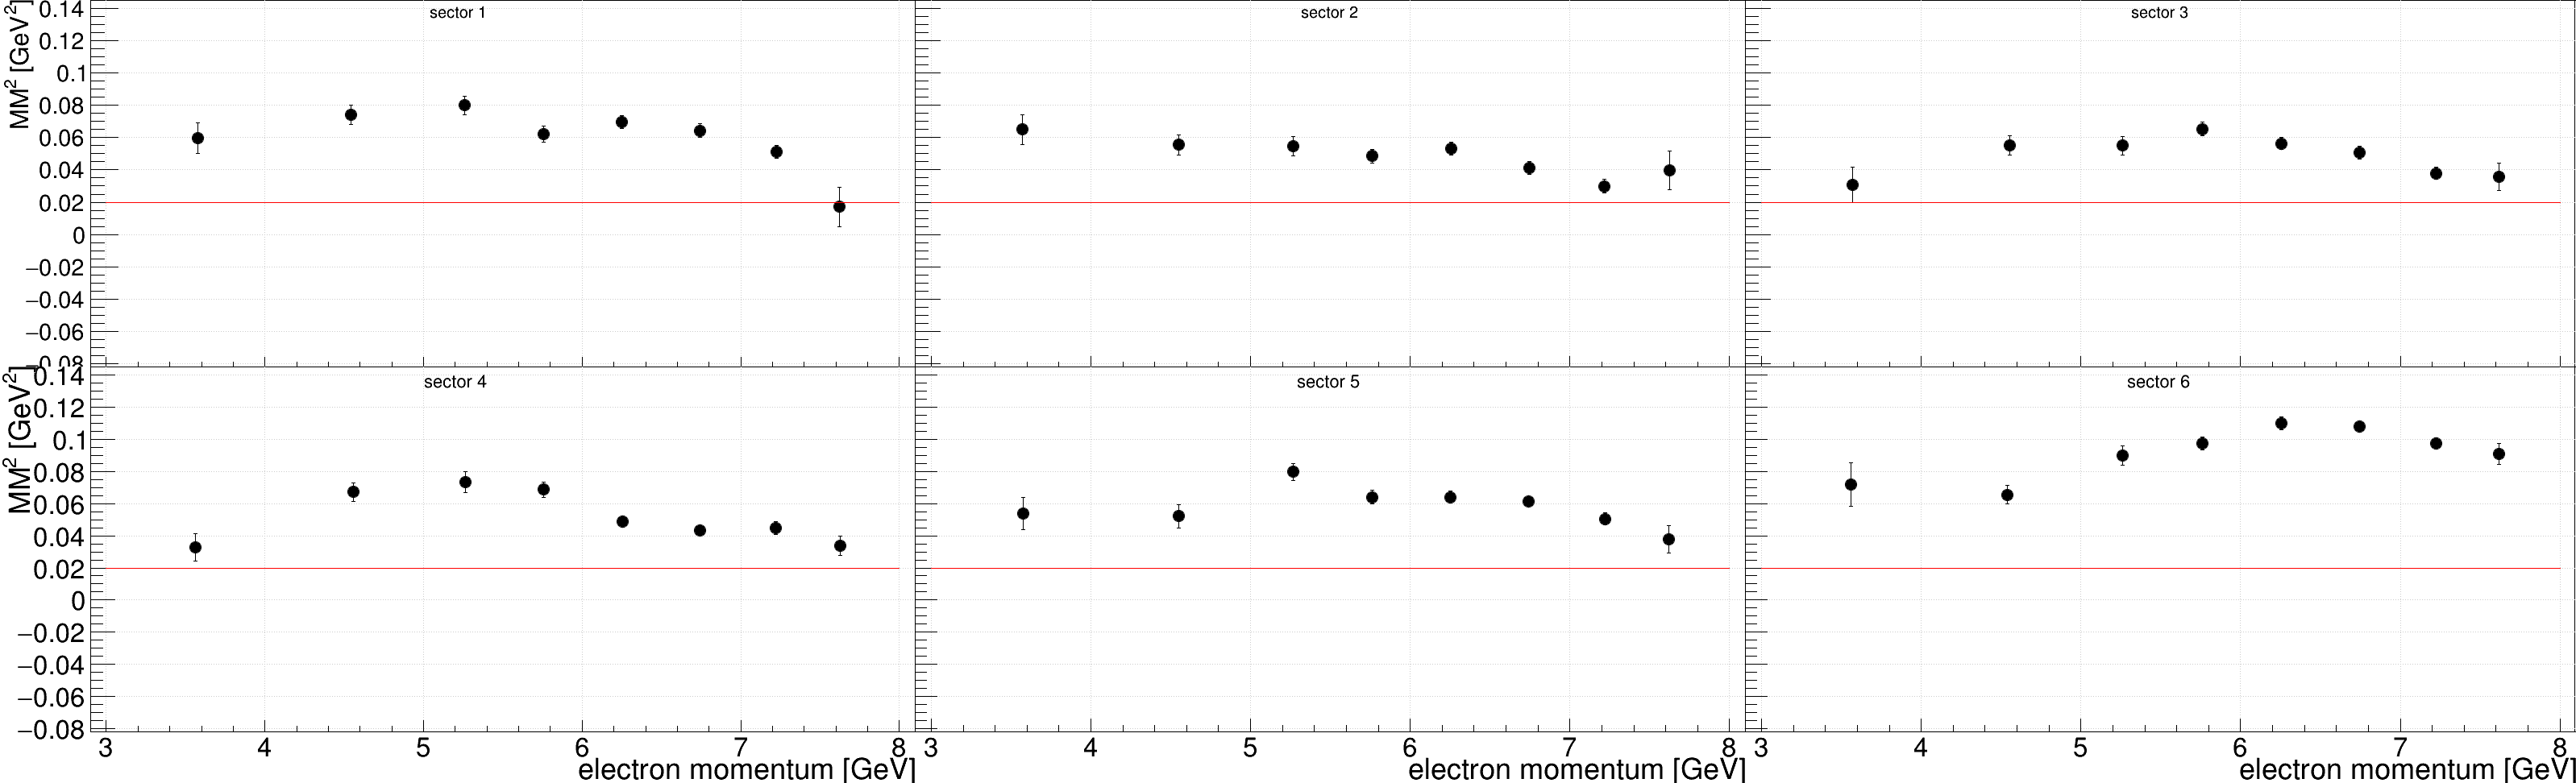

In [6]:
c1 = ROOT.TCanvas("c1","canvas",3200,1000)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

ll = ROOT.TLine()
ll.SetLineColor(2)

fout = ROOT.TFile(f"uncorrected.{dsid}.root","recreate")
for sec in range(1,7):
    c1.cd(sec).DrawFrame(2.9,-0.063,8.1,0.089).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    if 'outb' in fname: c1.cd(sec).DrawFrame(2.9,-0.082,8.1,0.145).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")

    h2a = h2as[sec-1]
    h2a.gr.SetMarkerStyle(20)
    
    h2a.gr.Draw("P")
    h2a.gr.Write(f"gr{sec}")
    
    ll.DrawLine(3,0.02,8,0.02)
fout.Close()
c1.Print(f"../pdf/eppi0.ecorr.mm2vspe.graph0.{dsid}.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


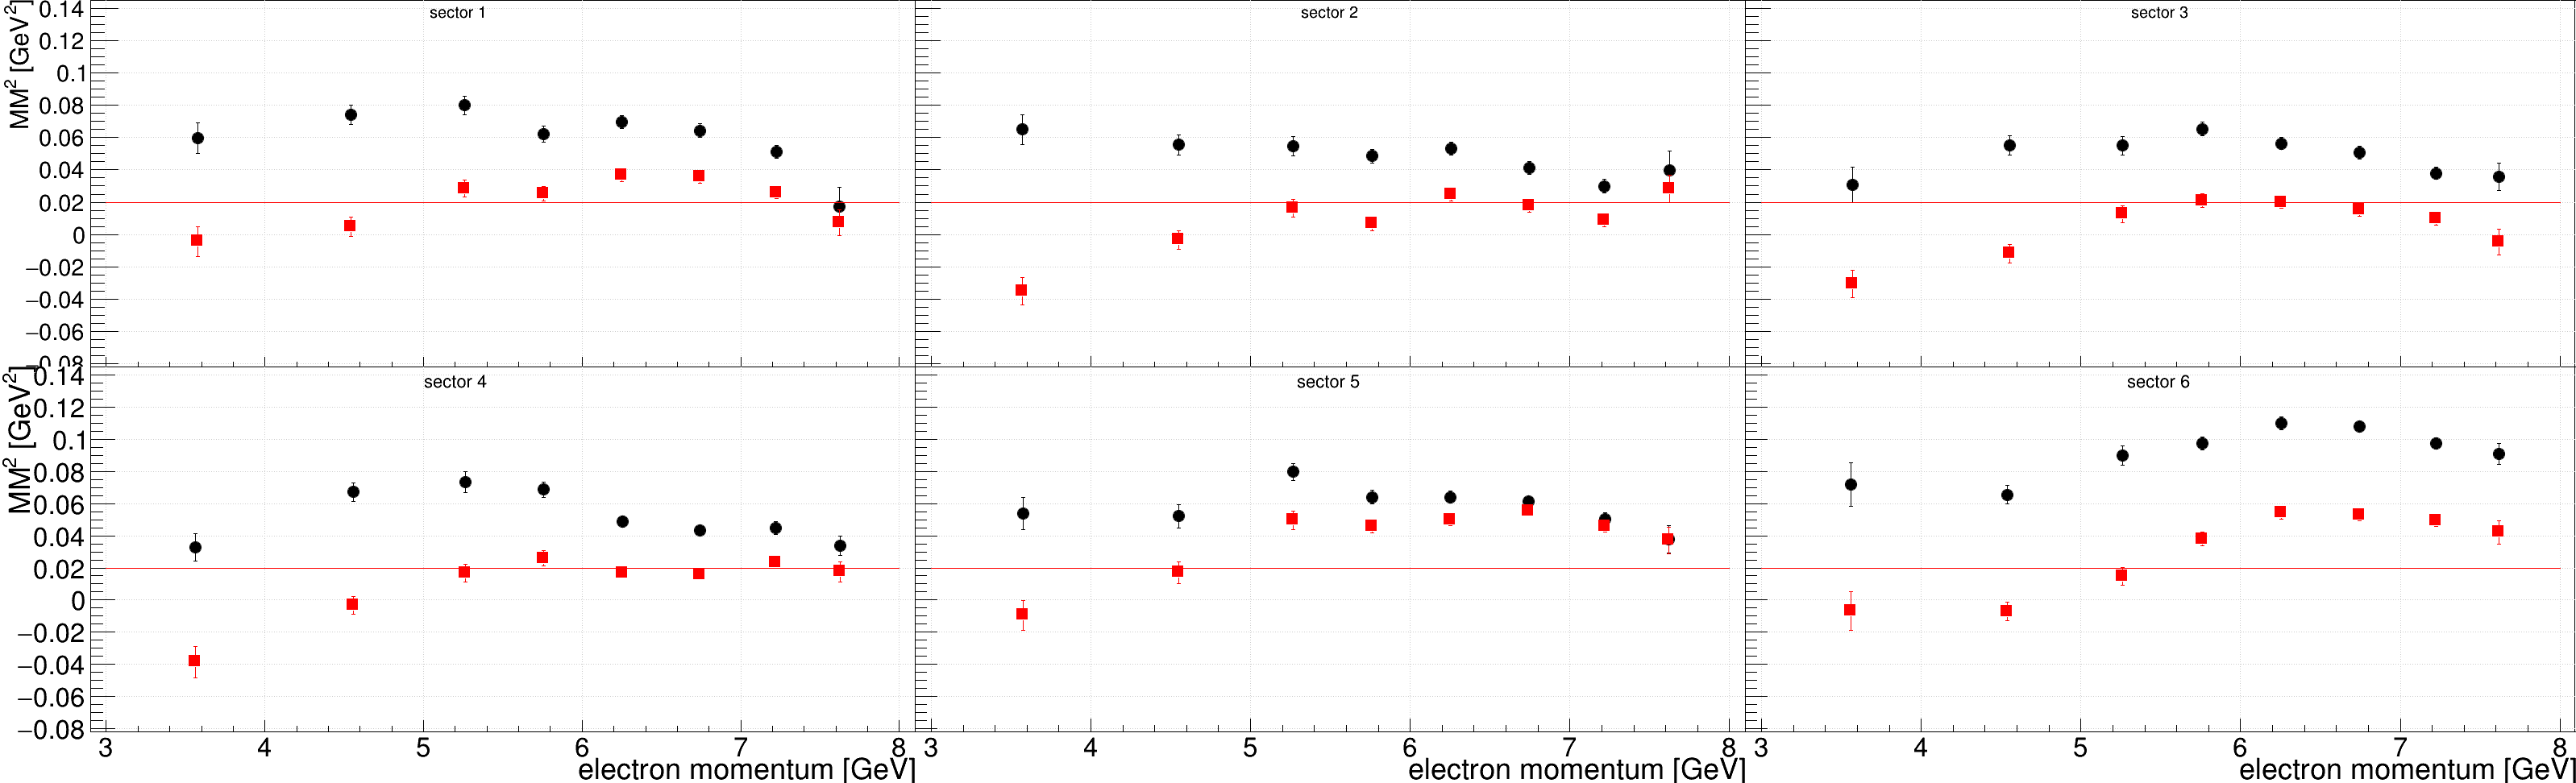

In [7]:
c1 = ROOT.TCanvas("c1","canvas",3200,1000)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

ll = ROOT.TLine()
ll.SetLineColor(2)


for sec in range(1,7):
    c1.cd(sec).DrawFrame(2.9,-0.063,8.1,0.089).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    if 'outb' in fname: c1.cd(sec).DrawFrame(2.9,-0.082,8.1,0.145).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    h2a,h2b = h2as[sec-1],h2bs[sec-1]
    h2a.gr.SetMarkerStyle(20)
    h2b.gr.SetMarkerStyle(21)

    h2b.gr.SetMarkerColor(2)
    h2b.gr.SetLineColor(2)

    h2a.gr.Draw("P")
    h2b.gr.Draw("P")
    
    ll.DrawLine(3,0.02,8,0.02)
    
c1.Print(f"../pdf/eppi0.ecorr.mm2vspe.graph1.{dsid}.pdf")

# Plot inbending and outbending together

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


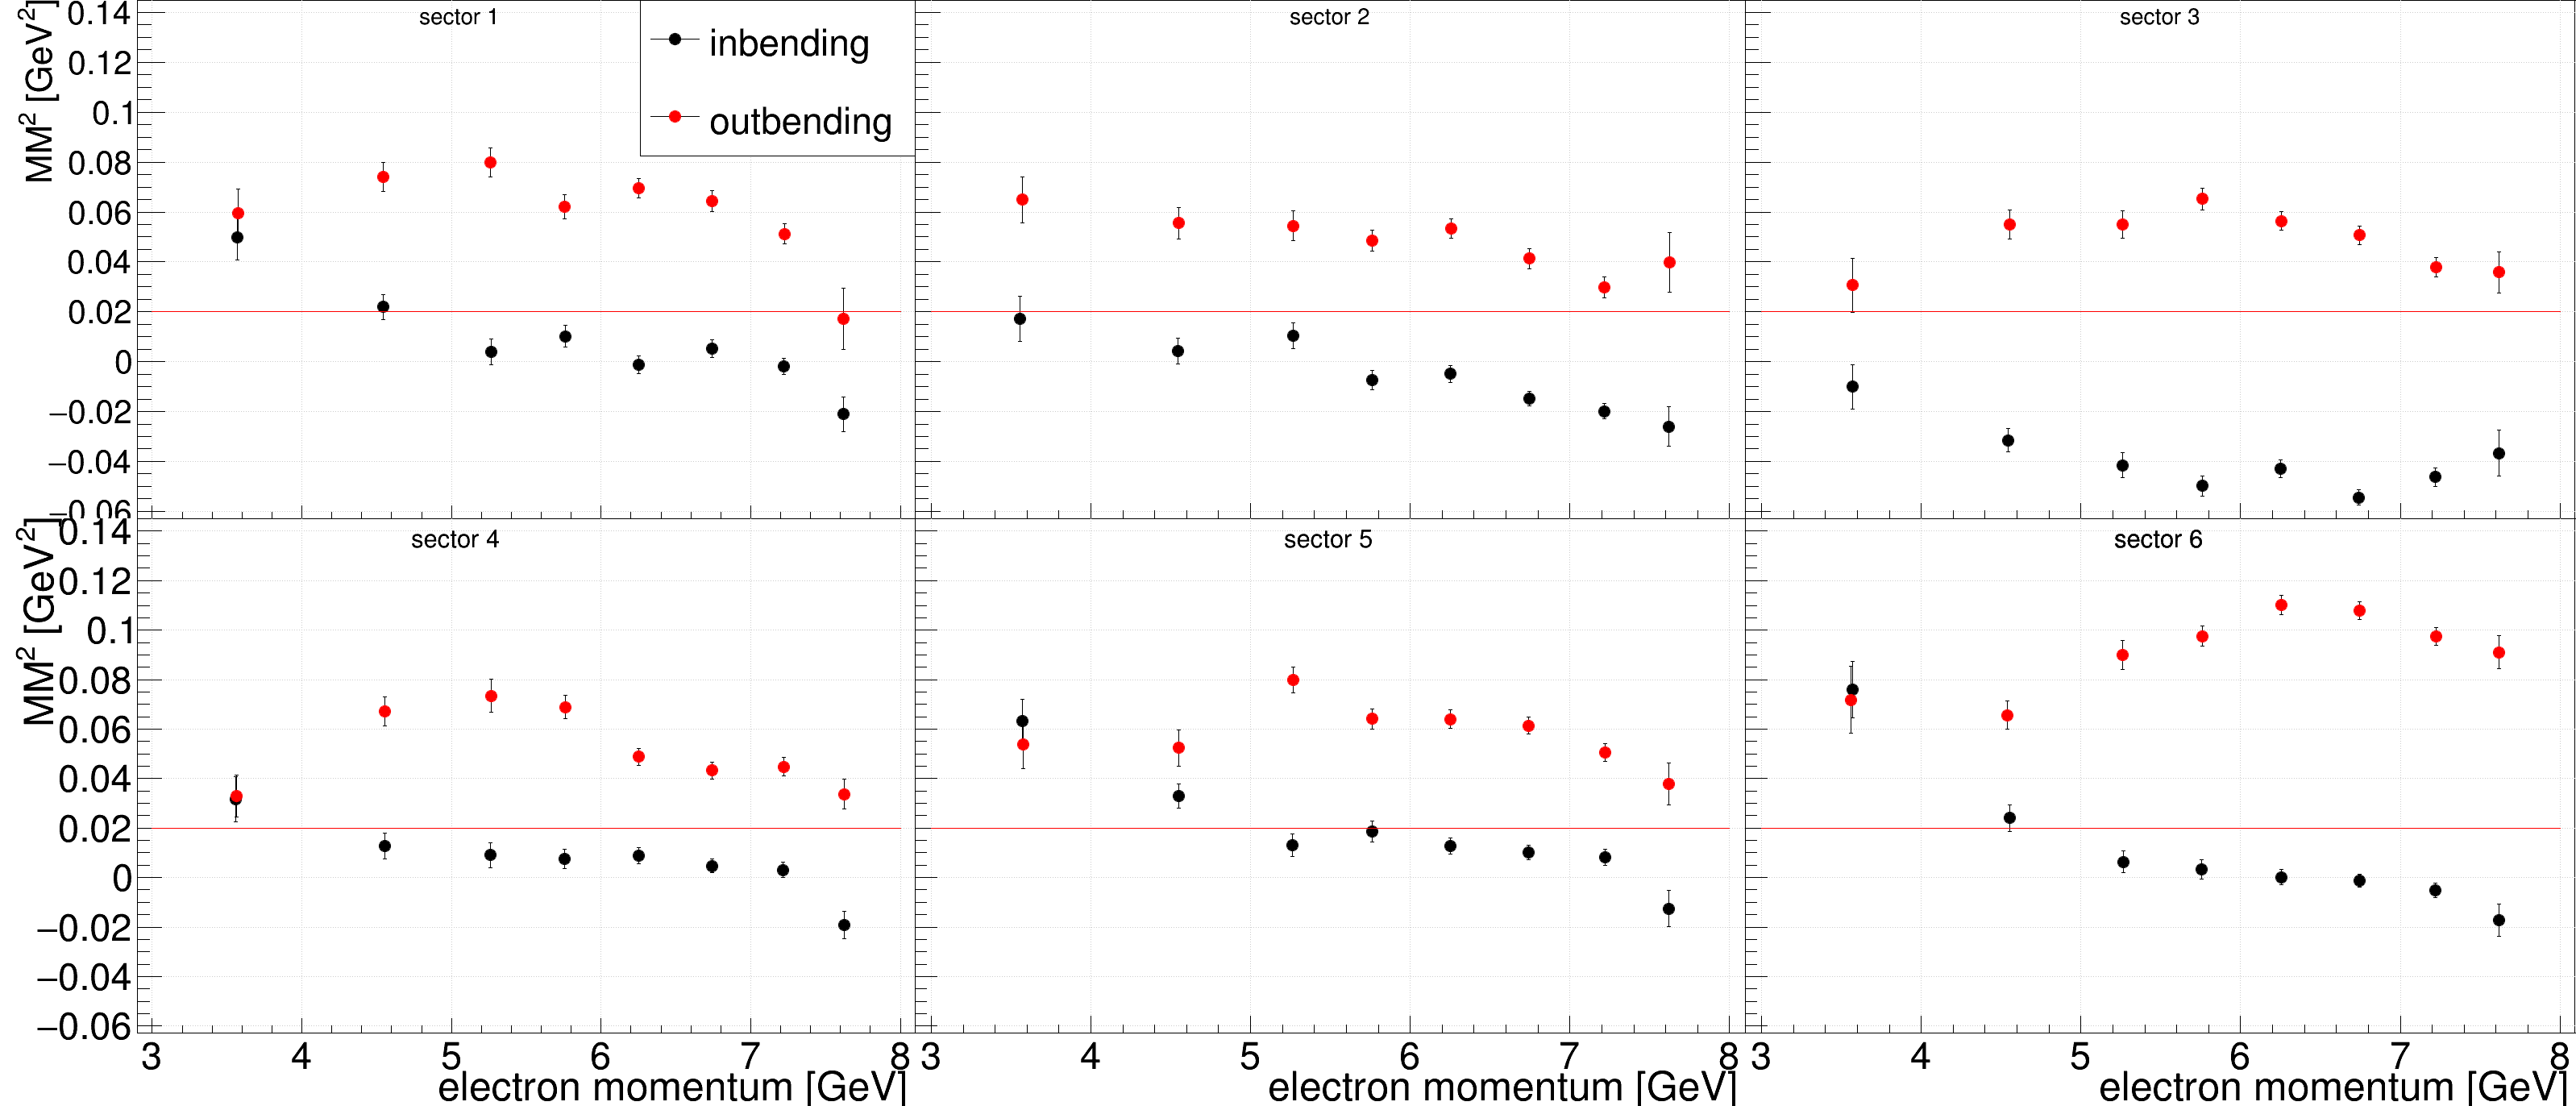

In [12]:
c1 = ROOT.TCanvas("c1","canvas",3200,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

ll = ROOT.TLine()
ll.SetLineColor(2)

ROOT.gStyle.SetTitleOffset(0.9,'y')
grs = []
for fn in ["uncorrected.inb.root", "uncorrected.outb.root"]:
    fin = ROOT.TFile(fn)
    for sec in range(1,7):
        gr = fin.Get(f"gr{sec}").Clone(f"gr{sec}.{fn}")
        grs.append(gr)

leg = ROOT.TLegend(0.7,0.7,1,1)
for sec in range(1,7):
    c1.cd(sec).DrawFrame(2.9,-0.063,8.1,0.145).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    if sec==1 or sec==4:
        c1.cd(sec).SetLeftMargin(0.15)

    grs[sec-1].Draw("P")
    grs[sec+5].Draw("P")
    if sec==1:
        leg.Draw()
        leg.AddEntry(grs[sec-1], "inbending","LP")
        leg.AddEntry(grs[sec+5], "outbending","LP")

    grs[sec+5].SetMarkerColor(2)
    
    ll.DrawLine(3,0.02,8,0.02)
